In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/shipwrecks-sunk-ships/Shipwrecks or Sunk ships.csv', parse_dates=['Sunk date'])
df.head()

,Ship,Flag,Sunk date,Notes,Coordinates
0,Black Assarca shipwreck,Unknown,Early 7th century (Presumed),A wreck discovered at Black Assarca Island in ...,NaN
1,Globe Star,Singapore,27-Apr-73,A cargo ship that ran aground off Mombasa.[1],4°04′54″S 39°43′12″E
2,Gulland,Aden,13-Apr-51,A 545-ton Isles-class trawler built for World ...,04°02′50″S 39°43′57″E
3,Mtongwe,Tanzania,27-Apr-94,A Likoni and Mombasa route ferry that capsized...,NaN
4,Katina P,Greece,26-Apr-92,"An oil tanker that was damaged in a storm, spi...",25°35′S 32°59′E


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3971 entries, 0 to 3970
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Ship         3952 non-null   object
 1   Flag         3202 non-null   object
 2   Sunk date    3573 non-null   object
 3   Notes        3914 non-null   object
 4   Coordinates  1019 non-null   object
dtypes: object(5)
memory usage: 155.2+ KB


<Axes: ylabel='Frequency'>

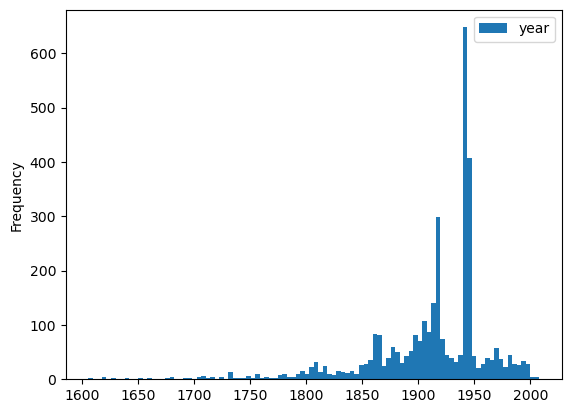

In [3]:
from numpy import nan
def get_year(arg) -> float:
    if isinstance(arg, float):
        return arg
    if isinstance(arg, str):
        if arg.isnumeric():
            return int(arg)
    pieces = arg.split('-')
    if pieces[-1].isnumeric():
        return 1900 + int(pieces[-1])
    pieces = arg.split()
    if pieces[-1].isnumeric():
        return int(pieces[-1])
    return nan
df['year'] = df['Sunk date'].apply(get_year)
# we can cut off the left tail of the histogram and not lose any story
df[df['year'] > 1600][['year']].plot.hist(bins=100)

Are we shocked that they cluster around World War II? We are not.

What percentage of cases have something possibly useful in the Sunk date column but we don't yet know the year?

In [4]:
100 * round(len(df[(df['year'].isna()) & (df['Sunk date'] != 'Unknown')])/len(df), 2)

12.0